In [63]:
#Expanation
#This is to plot the hydraulic conductivity of our study region
#based on the transmissivity calculated by Dr. George Roadcap in 1993

In [2]:
#First import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as spo
import scipy.special as sps
import math
import cartopy
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
from pykrige.uk import UniversalKriging
import pylab
import xlrd
import urllib, json
from datetime import datetime
import pyproj
from random import randint

#Turn on the next line if you want to see the full dataframe
#pd.set_option("display.max_rows", None, "display.max_columns", None)

roadcap_csv = 'trans_roadcap.csv'
transmissivity = pd.read_csv(roadcap_csv)

print(transmissivity)

#Conversion from Lambert to Lat/Long provided by Marissa 
illimap= {'proj': 'lcc', # Lambert Conformal Conic
     'ellps': 'clrk66', #Clarke 1866 ellipsoid
     'lon_0': -89.5, #Central Meridian
     'lat_0': 33, #Latitude of Origin
     'lat_1': 33, #Standard Parallel 1
     'lat_2': 45, #Standard Parallel 2
     'x_0': 2999994*0.3048006096012192, #starting x-coord. in ft, python expects m
     'y_0': 0} #starting y-coord.

wgs84= pyproj.Proj('epsg:4326') #Standard lat/long coordinates

       lam_x    lam_y   K (ft2/day)
0    3375623  3039827   1000.000000
1    3476309  3132249   1000.000000
2    3352371  3128153   6033.162181
3    3352770  3128169   8866.128063
4    3352770  3128169   3294.359574
..       ...      ...           ...
244  3533272  3130052    109.505769
245  3533558  3068468   3988.448604
246  3534773  3090075  17955.768600
247  3535931  3066355   7952.414344
248  3536775  3030318  14299.998770

[249 rows x 3 columns]


In [3]:

#Our assumed thickness of the top of the fractured dolomite
transmissivity['thickness'] = 50

#transmissivity['T'] = transmissivity['K (ft2/day)'] - transmissivity['thickness']
Latitude=[] 
Longitude=[]



for index, row in transmissivity.iterrows():
  from pyproj import Proj, transform
  inProj = Proj(illimap) #define input projection
  outProj = wgs84 #define output projection
  Long1,Lat1 = (0.3048006096012192*row['lam_x'],0.3048006096012192*row['lam_y']) #define input coordinates; convert lambert ft to m
  Long2,Lat2 = transform(inProj,outProj,Long1,Lat1) #convert from lambert to wgs84
  Latitude.append(Lat2) #add latitude data to empty Latitude=[] array
  Longitude.append(Long2) #add longitude data to empty Longitude=[] array

 
   
transmissivity['Latitude']=Latitude
transmissivity['Longitude']=Longitude
transmissivity=transmissivity.drop(['lam_x','lam_y'],axis=1)




In [10]:
#transmissivity['L']
transmissivity.rename(columns = {'Latitude':'longitude'}, inplace = True) 
transmissivity.rename(columns = {'Longitude':'latitude'}, inplace = True)
transmissivity.rename(columns = {'K (ft2/day)':'T (ft2/day)'}, inplace = True)


transmissivity['K (ft/day)'] = transmissivity['T (ft2/day)'] /( transmissivity['thickness']*7.46)
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(transmissivity)


      T (ft2/day)  thickness  longitude   latitude   K (ft/day)
0    1.000000e+03         50 -88.124981  41.374972     2.680965
1    1.000000e+03         50 -87.749979  41.624971     2.680965
2    6.033162e+03         50 -88.205480  41.619404    16.174698
3    8.866128e+03         50 -88.204013  41.619433    23.769780
4    3.294360e+03         50 -88.204013  41.619433     8.832063
5    3.443642e+03         50 -88.204052  41.542976     9.232284
6    1.083817e+04         50 -88.203282  41.549489    29.056759
7    8.149182e+03         50 -88.144094  41.569593    21.847672
8    5.910919e+04         50 -88.139033  41.561576   158.469675
9    1.208807e+04         50 -88.133270  41.700673    32.407697
10   8.684884e+03         50 -88.128597  41.563419    23.283870
11   6.098949e+03         50 -88.128491  41.554787    16.351070
12   5.805064e+05         50 -88.123471  41.698508  1556.317383
13   1.510000e+03         50 -88.125429  41.507419     4.048258
14   1.538498e+04         50 -88.120414 

In [5]:
UK = UniversalKriging(transmissivity['longitude'], transmissivity['latitude'], transmissivity['K (ft/day)'], variogram_model='spherical')

/Users/ceciliacullen/anaconda2/envs/py36/lib/python3.6/site-packages/pykrige/core.py:823: RuntimeWarning: invalid value encountered in sqrt
  sigma[i] = np.sqrt(ss)
/Users/ceciliacullen/anaconda2/envs/py36/lib/python3.6/site-packages/pykrige/core.py:828: RuntimeWarning: invalid value encountered in greater
  delta = delta[sigma > eps]
/Users/ceciliacullen/anaconda2/envs/py36/lib/python3.6/site-packages/pykrige/core.py:829: RuntimeWarning: invalid value encountered in greater
  sigma = sigma[sigma > eps]


In [6]:
#minlat = 41.21
#maxlat = 41.72
#minlong = -88.20
#maxlong = -87.55


minlat = 41.25 #minimum latitude for map extent
maxlat = 41.80 #maximum latitude for map extent
minlong = -88.25 #minimum longitude for map extent
maxlong = -88.0 #maximum longitude for map extent



# create xpoints and ypoints in space, with 0.01 spacing
xpoints = np.arange(minlong,maxlong, 0.01)
ypoints = np.arange(minlat, maxlat,0.01)
#print(xpoints)
# create a meshgrid with xpoints and ypoints, to be used later in the code
X,Y = np.meshgrid(xpoints, ypoints)

UK = UniversalKriging(transmissivity['longitude'], transmissivity['latitude'], transmissivity['K (ft/day)'], variogram_model='linear', nlags = 6)


# Calculate the interpolated grid and fill values with the head difference in the geographic space defined 
z_3, var = UK.execute('grid', xpoints,ypoints)
z_3 = z_3.filled(fill_value=None)
print(z_3)


[[157.38362955 157.46915573 157.58231619 ... 168.99324287 170.16824168
  171.42702202]
 [157.01971826 157.08879032 157.18576899 ... 168.77293913 169.98646872
  171.27640131]
 [156.66153526 156.71308003 156.79268797 ... 168.52887089 169.77816056
  171.09962614]
 ...
 [190.07026029 191.22199625 192.42771459 ... 209.87496773 209.24894013
  208.47059465]
 [190.48564477 191.59902699 192.75796684 ... 208.65707833 208.05816391
  207.31041634]
 [190.80993795 191.88147801 192.99084927 ... 207.41683199 206.83480636
  206.10913633]]


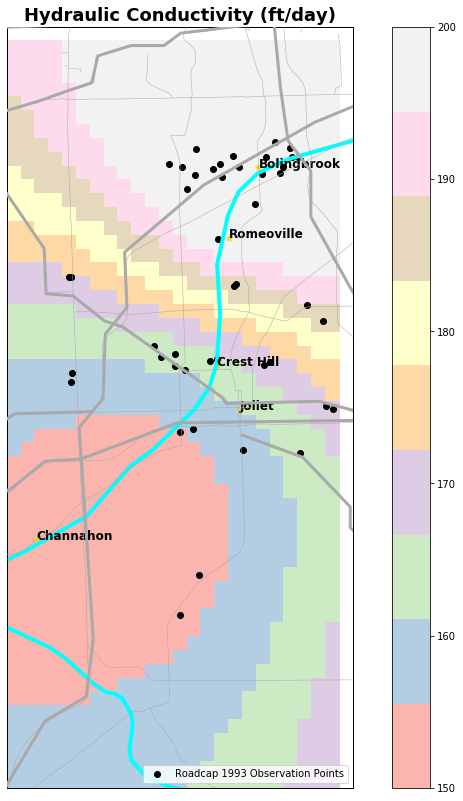

In [9]:
# Create a figure and set size 
fig = plt.figure(figsize=(14, 14))

# define a projection
ax = plt.axes(projection=ccrs.PlateCarree())

# define spatial domain to plot
ax.set_xlim(minlong,maxlong)
ax.set_ylim(minlat,maxlat)


# we are now going to use CartoPy to import state bordes and populated areas 
states_provinces = cf.NaturalEarthFeature(
    category='cultural', # features are categorized as cultural or physical
    name='admin_1_states_provinces', # name of shapefile
    scale='110m', # scale of features
    facecolor='none')	

popplaces = cf.NaturalEarthFeature(
    category='cultural',
    name='urban_areas', # plots municipal boundaries
    #name_attributes = 'on',
    scale='10m',
    facecolor='none') 

#second defining major rivers
largerivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='110m', # major rivers
    facecolor='none')

#third defining smaller rivers
smallrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines_scale_rank',
    scale='10m', # smaller rivers (still considered major by many/most people)
    facecolor='none')   

#third defining smaller rivers
smallestrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_north_america',
    scale='10m', # smaller rivers (still considered major by many/most people)
    facecolor='none')   

#roads
interstates = cf.NaturalEarthFeature(
    category='cultural',
    name='roads', 
    scale='10m',
    facecolor='black') 

#smaller roads
smallroads = cf.NaturalEarthFeature(
    category='cultural',
    name='roads_north_america', 
    scale='10m',
    facecolor='red') 

# adds the features defined above; zorder allows you to choose the order map is layered
ax.add_feature(largerivers,edgecolor='aqua',linewidth=4.0, zorder=2)
ax.add_feature(smallrivers,edgecolor='aqua',linewidth=4.0, zorder=2)
ax.add_feature(smallestrivers,edgecolor='aqua',linewidth=4.0, zorder=2)
ax.add_feature(interstates, edgecolor='darkgray', facecolor = '',linewidth=3.0,zorder=3)
ax.add_feature(smallroads, edgecolor='darkgray', facecolor = '',linewidth=0.5,zorder=3)


# This sets the what will be used to create the color ramp and what color scheme I choose
cset = plt.pcolor(X, Y, z_3, cmap='Pastel1')
plt.clim(150, 200) 

# This plots the well points 
plt.scatter(transmissivity['longitude'], transmissivity['latitude'],  marker="o", color="black", label="Roadcap 1993 Observation Points")


#This is the title of the plot with reference to the date as presented in the dataframe 
plt.title('Hydraulic Conductivity (ft/day)', fontsize=18, fontweight='bold')

#This line generates the colorbar 
fig.colorbar(cset, ax=ax)


#This plots the legend and places it in the lower right
plt.legend(loc='lower right')

#Just to get some reference of communities' locations 
lons = [-88.0987, -88.0684, -88.0817, -88.0895, -88.2287]
lats = [41.5548, 41.6986, 41.5230, 41.6475, 41.4295]
labels = ['Crest Hill', 'Bolingbrook', 'Joliet', 'Romeoville', 'Channahon']
plt.scatter(lons, lats, marker="*", color="gold" )

#This puts the labels on the map
for i, txt in enumerate(labels):
    ax.annotate(txt,(lons[i], lats[i]),  fontsize=12, fontweight='bold')


#Double voila! Show COLORFUL MAP!!!!!!!
plt.show()